In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from tqdm.auto import tqdm

In [3]:
import data
import utils

In [4]:
readerTypes = [data.CacuData, data.FccPmData, data.SuperconductivityData, data.GarmentProductivityData]
targets = ['ViolentCrimesPerPop', 'PM', 'critical_temp', 'actual_productivity']

In [5]:
mse_collector = {}

for ReaderType, target in zip(readerTypes, targets):
    reader = ReaderType('data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')
    reader.readAndCache()
    print("---------")
    print("Dataset:", reader.name)
    cols = reader.cols
    ncols = len(cols)
    colcomb = list(itertools.combinations(cols, 2))
    colcomb_lim = [(a,b) for a,b in np.random.permutation(colcomb)]
    
    trainer = utils.Trainer(
        cache_dir='models_clean',
        default_params={
            'objective': 'regression',
            'metric': 'mse',
            'boosting': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'verbose': -1,
            'device': 'cpu',
            'lambda_l2': 0.003,
            'early_stopping_round': 10,
            'num_boost_round': 100,
        },
        nocache_params={
            'num_threads': 20,
        }
    )
    evaluator = utils.Evaluator(reader, target)
    
    data_mse = {}
    
    col_mse = {}
    for c in tqdm(cols):
        trainData = utils.TrainingData(reader, target, columns=[c])
        booster = trainer.train_model(trainData)
        new_mse = evaluator.get_model_mse(booster)
        col_mse[c] = new_mse

    col2_mse_e = {}
    for columns in tqdm(colcomb_lim):
        trainData = utils.TrainingData(reader, target, columns=list(columns))
        booster = trainer.train_model(trainData)
        new_mse = evaluator.get_model_mse(booster)
        col2_mse_e[columns] = new_mse
        
    col2_mse_er = {}
    for columns in tqdm(colcomb_lim):
        trainData = utils.TrainingData(reader, target, columns=list(columns))
        booster = trainer.train_model(trainData, override_params={
            'interaction_constraints': [[0],[1]],
        })
        new_mse = evaluator.get_model_mse(booster)
        col2_mse_er[columns] = new_mse
        
    mse_collector[reader.name] = {
        'col_mse': col_mse,
        'col2_mse_e': col2_mse_e,
        'col2_mse_er': col2_mse_er,
        'base_mse': evaluator.base_mse,
        'nsamples': len(colcomb_lim)
    }

---------
Dataset: Communities and Crime Unnormalized


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/7626 [00:00<?, ?it/s]

  0%|          | 0/7626 [00:00<?, ?it/s]

---------
Dataset: PM2.5 Data of Five Chinese Cities


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

---------
Dataset: Superconductivity


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/3240 [00:00<?, ?it/s]

  0%|          | 0/3240 [00:00<?, ?it/s]

---------
Dataset: Productivity Prediction of Garment Employees


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

In [6]:
W_collector = {}
for dataset, mse_dict in mse_collector.items():
    W_list = []
    WR_list = []
    for col1, col2 in mse_dict['col2_mse_e'].keys():
        l_xy = mse_dict['base_mse'] - mse_dict['col2_mse_e'][(col1, col2)]
        lr_xy = mse_dict['base_mse'] - mse_dict['col2_mse_er'][(col1, col2)]
        l_x = mse_dict['base_mse'] - mse_dict['col_mse'][col1]
        l_y = mse_dict['base_mse'] - mse_dict['col_mse'][col2]
        w = (l_xy - l_x - l_y)
        wr = (lr_xy - l_x - l_y)
        W_list.append(w)
        WR_list.append(wr)
    W_collector[dataset] = {
        'W_list': np.array(W_list)/mse_dict['base_mse'],
        'WR_list': np.array(WR_list)/mse_dict['base_mse'],
        'nsamples': mse_dict['nsamples']
    }

In [7]:
short_titles = {
    'Communities and Crime Unnormalized': 'CaCU',
    'PM2.5 Data of Five Chinese Cities': 'PM2.5',
    'Superconductivity': 'Superconductivity',
    'Productivity Prediction of Garment Employees': 'Garment',
}

In [8]:
W_collector[dataset]['WR_list'].max()

0.08796055845651

Communities and Crime Unnormalized -0.03870440802205259 -0.05055253375841283
PM2.5 Data of Five Chinese Cities 0.014941981793618749 0.007387763351374015
Superconductivity -0.27920484995517597 -0.35520391626539155
Productivity Prediction of Garment Employees 0.006938077492829442 -0.0056575238492362415


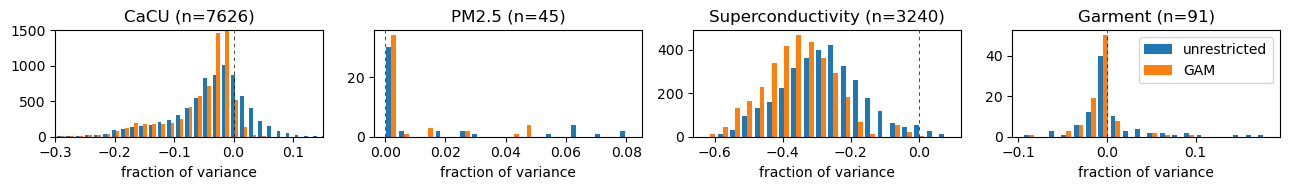

In [9]:
ylims = [1500, None, None, None]
bins = [40, 20, 20, 20]
xlim = [(-0.3,0.15), None, None, None]
fig=plt.figure(figsize=(13,2))
for i, dataset in enumerate(W_collector):
    print(dataset, W_collector[dataset]['W_list'].mean(), W_collector[dataset]['WR_list'].mean())
    plt.subplot(1, 4, i+1)
    plt.title(short_titles[dataset]+" (n=%d)"%W_collector[dataset]['nsamples'])
    plt.hist([W_collector[dataset]['W_list'], W_collector[dataset]['WR_list']], bins=bins[i], label=['unrestricted', 'GAM'])
    plt.xlabel('fraction of variance')
    plt.axvline(x = 0, color = 'k', lw=0.5, linestyle=(0,(5,5)))
    plt.ylim(0, ylims[i])
    if xlim[i]:
        plt.xlim(*xlim[i])
    plt.tight_layout()
    if(i==3):
        plt.legend()
#fig.suptitle('Distribution of $W$ and $W^r$ values between pairs of features')
plt.tight_layout()
plt.savefig('output/alldata_w_dist.pdf')
plt.savefig('output/alldata_w_dist.png')

# Covariances

In [10]:
list(mse_collector.keys())

['Communities and Crime Unnormalized',
 'PM2.5 Data of Five Chinese Cities',
 'Superconductivity',
 'Productivity Prediction of Garment Employees']

In [11]:
mse_dict = mse_collector['PM2.5 Data of Five Chinese Cities']
neg_pairs_pm = []
for col1, col2 in mse_dict['col2_mse_e'].keys():
    lr_xy = mse_dict['base_mse'] - mse_dict['col2_mse_er'][(col1, col2)]
    l_x = mse_dict['base_mse'] - mse_dict['col_mse'][col1]
    l_y = mse_dict['base_mse'] - mse_dict['col_mse'][col2]
    wr = (lr_xy - l_x - l_y)
    if wr/mse_dict['base_mse'] >= 0.01:
        neg_pairs_pm.append((col1, col2, wr, mse_dict['base_mse']))

In [12]:
reader = data.FccPmData('data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')
target = 'PM'
datapoints1 = []
for col1,col2,wr,base_mse in neg_pairs_pm:
    trainData = utils.TrainingData(reader, target, columns=[col1,col2])
    booster = trainer.train_model(trainData, override_params={
        'interaction_constraints': [[0],[1]],
    })
    covmat = utils.get_group_cov(booster, reader.test, [[0],[1]])
    print(covmat[0,1]/base_mse, wr/base_mse)
    datapoints1.append((covmat[0,1], wr/base_mse))

0.0033209277742301735 0.014713690446684457
-0.006099305570056018 0.01248752884099524
-0.007474329820906446 0.02707056557380786
0.004679972646380751 0.04526503834597302
0.007534640019867239 0.04850737792560036
0.0034988615401515735 0.04745506900786973
0.0033874425838325275 0.015670220701417773
-0.011632510953979493 0.025081821218096885
0.004763180855915268 0.043076301495409995
-0.0004902929960906632 0.04515490391551901


In [13]:
mse_dict = mse_collector['Productivity Prediction of Garment Employees']
neg_pairs_garment = []
for col1, col2 in mse_dict['col2_mse_e'].keys():
    lr_xy = mse_dict['base_mse'] - mse_dict['col2_mse_er'][(col1, col2)]
    l_x = mse_dict['base_mse'] - mse_dict['col_mse'][col1]
    l_y = mse_dict['base_mse'] - mse_dict['col_mse'][col2]
    wr = (lr_xy - l_x - l_y)
    if wr/mse_dict['base_mse'] >= 0.03:
        neg_pairs_garment.append((col1, col2, wr, mse_dict['base_mse']))

In [14]:
reader = data.GarmentProductivityData('data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')
target = 'actual_productivity'
datapoints2 = []
for col1,col2,wr,base_mse in neg_pairs_garment:
    trainData = utils.TrainingData(reader, target, columns=[col1,col2])
    booster = trainer.train_model(trainData, override_params={
        'interaction_constraints': [[0],[1]],
    })
    covmat = utils.get_group_cov(booster, reader.test, [[0],[1]])
    print(covmat[0,1]/base_mse, wr/base_mse)
    datapoints2.append((covmat[0,1], wr/base_mse))

-0.009187419456654604 0.0549669335924338
-0.007300577160517996 0.06664500764730955
-0.0002692198018009847 0.05070142766815486
-0.018788525059132172 0.08796055845651


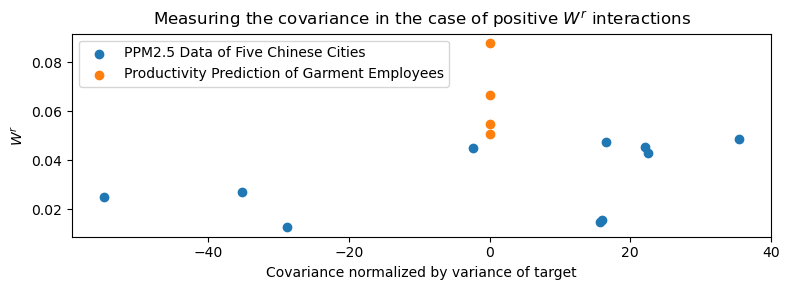

In [15]:
plt.figure(figsize=(8,3))
plt.title('Measuring the covariance in the case of positive $W^r$ interactions')
plt.scatter(*np.array(datapoints1).T, label="PPM2.5 Data of Five Chinese Cities")
plt.scatter(*np.array(datapoints2).T, label="Productivity Prediction of Garment Employees")
plt.xlabel('Covariance normalized by variance of target')
plt.ylabel('$W^r$')
plt.legend()
plt.tight_layout()
plt.savefig('output/cov_vs_wr_pm_garment.pdf')
plt.savefig('output/cov_vs_wr_pm_garment.png')

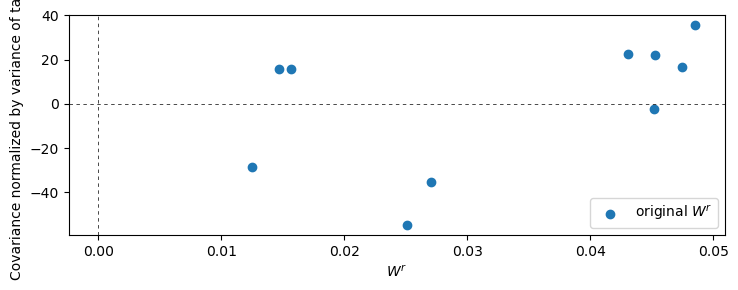

In [16]:
plt.figure(figsize=(7.5,3))
#plt.title('Measuring the covariance in the case of positive $W^r$ interactions')
plt.scatter(*np.array(datapoints1).T[::-1], label='original $W^r$')
plt.xlabel('$W^r$')
plt.ylabel('Covariance normalized by variance of target')
plt.axvline(x = 0, color = 'k', lw=0.5, linestyle=(0,(5,5)))
plt.axhline(y = 0, color = 'k', lw=0.5, linestyle=(0,(5,5)))
plt.legend()
plt.tight_layout()
plt.savefig('output/cov_vs_wr_orig.pdf')
plt.savefig('output/cov_vs_wr_orig.png')

In [17]:
mse_collector_2 = {}

for ReaderType, target in zip(readerTypes[1:2], targets[1:2]):
    reader = ReaderType('data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')
    reader.readAndCache()
    print("---------")
    print("Dataset:", reader.name)
    cols = reader.cols
    ncols = len(cols)
    colcomb = list(itertools.combinations(cols, 2))
    colcomb_lim = [(a,b) for a,b in np.random.permutation(colcomb)]
    
    trainer = utils.Trainer(
        cache_dir='models_clean',
        default_params={
            'objective': 'regression',
            'metric': 'mse',
            'boosting': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'verbose': -1,
            'device': 'cpu',
            'lambda_l2': 0.003,
            'early_stopping_round': 10,
            'num_boost_round': 100,
        },
        nocache_params={
            'num_threads': 20,
        }
    )
    evaluator = utils.Evaluator(reader, target)
    
    data_mse = {}
    
    col_mse = {}
    for c in tqdm(cols):
        trainData = utils.TrainingData(reader, target, columns=[c])
        booster = trainer.train_model(trainData)
        new_mse = evaluator.get_model_mse(booster)
        col_mse[c] = new_mse

    col2_mse_e = {}
    for columns in tqdm(colcomb_lim):
        trainData = utils.TrainingData(reader, target, columns=list(columns))
        booster = trainer.train_model(trainData)
        new_mse = evaluator.get_model_mse(booster)
        col2_mse_e[columns] = new_mse
        
    col2_mse_er = {}
    for columns in tqdm(colcomb_lim):
        trainData = utils.TrainingData(reader, target, columns=list(columns))
        booster = trainer.train_model(trainData, override_params={
            'interaction_constraints': [[0],[1]],
        })
        new_mse = evaluator.get_model_mse(booster)
        col2_mse_er[columns] = new_mse


        features = pd.Series(booster.feature_name())
        group_masks = utils.get_feature_group_masks(booster, [[i] for i in features])
        tree_preds = utils.get_tree_predictions(booster, evaluator.eval)
        group_pred_parts = np.array([tree_preds.dot(mask) for mask in group_masks]).T

        second_part_mse = evaluator.get_mse(evaluator.eval_y, group_pred_parts[:, 1]-group_pred_parts[:, 1].mean() + evaluator.train_y.mean())

        f1 = booster.feature_name()[1]
        col_mse[f1] = min(second_part_mse, col_mse[f1])

    mse_collector_2[reader.name] = {
        'col_mse': col_mse,
        'col2_mse_e': col2_mse_e,
        'col2_mse_er': col2_mse_er,
        'base_mse': evaluator.base_mse,
        'nsamples': len(colcomb_lim)
    }

---------
Dataset: PM2.5 Data of Five Chinese Cities


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

In [18]:
mse_dict = mse_collector_2['PM2.5 Data of Five Chinese Cities']
neg_pairs_pm2 = []
for col1, col2, _, _ in neg_pairs_pm:
    lr_xy = mse_dict['base_mse'] - mse_dict['col2_mse_er'][(col1, col2)]
    l_x = mse_dict['base_mse'] - mse_dict['col_mse'][col1]
    l_y = mse_dict['base_mse'] - mse_dict['col_mse'][col2]
    wr = (lr_xy - l_x - l_y)
    neg_pairs_pm2.append((col1, col2, wr, mse_dict['base_mse']))

In [19]:
reader = data.FccPmData('data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')
target = 'PM'
datapoints3 = []
for col1,col2,wr,base_mse in neg_pairs_pm2:
    trainData = utils.TrainingData(reader, target, columns=[col1,col2])
    booster = trainer.train_model(trainData, override_params={
        'interaction_constraints': [[0],[1]],
    })
    covmat = utils.get_group_cov(booster, reader.test, [[0],[1]])
    print(col1, col2, covmat[0,1]/base_mse, wr/base_mse)
    datapoints3.append((covmat[0,1], wr/base_mse))

Iws precipitation 0.0033209277742301735 -0.09013283291335075
HUMI TEMP -0.006099305570056018 -0.12171141830403506
HUMI PRES -0.007474329820906446 -0.0820654819720758
TEMP Iws 0.004679972646380751 -0.12213904947912753
PRES Iws 0.007534640019867239 -0.09383381030035355
DEWP Iws 0.0034988615401515735 -0.11868421291036374
Iws Iprec 0.0033874425838325275 -0.09047739007427993
DEWP HUMI -0.011632510953979493 -0.10785232002006634
HUMI Iws 0.004763180855915268 -0.11797092777603974
season Iws -0.0004902929960906632 -0.09985303588953413


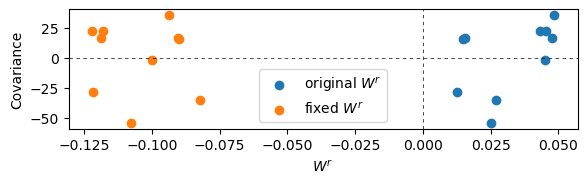

In [20]:
plt.figure(figsize=(6,2))
#plt.title('Measuring the covariance in the case of positive $W^r$ interactions')
plt.scatter(*np.array(datapoints1).T[::-1], label='original $W^r$')
plt.scatter(*np.array(datapoints3).T[::-1], label='fixed $W^r$')
plt.xlabel('$W^r$')
plt.ylabel('Covariance')
plt.axvline(x = 0, color = 'k', lw=0.5, linestyle=(0,(5,5)))
plt.axhline(y = 0, color = 'k', lw=0.5, linestyle=(0,(5,5)))
plt.legend()
plt.tight_layout()
plt.savefig('output/cov_vs_wr.pdf')
plt.savefig('output/cov_vs_wr.png')